In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6e3bd9c1-c29f-3484-bcd4-95221ddc82b6)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import helper_functions as hlp

--2024-01-01 14:29:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-01 14:29:49 (107 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
import tensorflow_datasets as tfds


(train_data,test_data),info = tfds.load('food101',
                                        split=['train','validation'],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True)

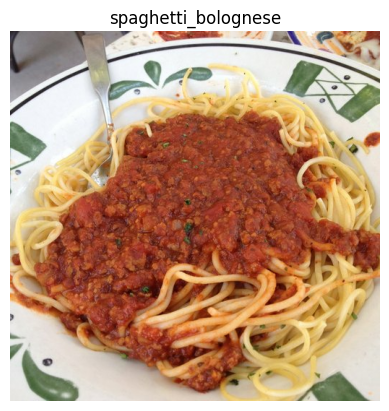

In [ ]:
class_names = info.features['label'].names
for img,label in test_data.take(1):
  plt.imshow(img)
  plt.title(class_names[label.numpy()])
  plt.axis('off')
  plt.show()

In [ ]:
import time
(train_data,test_data),info = tfds.load('food101',
                                        split=['train','validation'],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True)


def preprocess_data(image, label):
  image = tf.image.resize(image,[224,224])
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

tic = time.time()
train_data = train_data.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size = 1000)

train_data = train_data.batch(32)
test_data = test_data.batch(32)

train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE) # While process a batch prepare next one
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE) # AUTOTUNE will allow multithread use of CPU

# Can add .cache() method also when have enough RAM !
toc = time.time()

print(f'{(toc-tic)*1000//1/10} ms')

6.0 ms


In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# data_aug = tf.keras.models.Sequential([
#     tf.keras.layers.RandomFlip(),
#     tf.keras.layers.RandomHeight(0.2),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomWidth(0.2),
#     tf.keras.layers.RandomZoom(0.2),
# ])

input = tf.keras.layers.Input((224,224,3))


base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
x = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(101)(x)

output = tf.keras.layers.Activation('softmax',dtype='float32')(x)

model = tf.keras.models.Model(input,output)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

In [ ]:
for i,layer in enumerate(model.layers[1].layers[:20]) :
  print(i,layer.name,layer.dtype,layer.dtype_policy)

0 input_4 float32 <Policy "float32">
1 rescaling_2 float32 <Policy "mixed_float16">
2 normalization_1 float32 <Policy "mixed_float16">
3 rescaling_3 float32 <Policy "mixed_float16">
4 stem_conv_pad float32 <Policy "mixed_float16">
5 stem_conv float32 <Policy "mixed_float16">
6 stem_bn float32 <Policy "mixed_float16">
7 stem_activation float32 <Policy "mixed_float16">
8 block1a_dwconv float32 <Policy "mixed_float16">
9 block1a_bn float32 <Policy "mixed_float16">
10 block1a_activation float32 <Policy "mixed_float16">
11 block1a_se_squeeze float32 <Policy "mixed_float16">
12 block1a_se_reshape float32 <Policy "mixed_float16">
13 block1a_se_reduce float32 <Policy "mixed_float16">
14 block1a_se_expand float32 <Policy "mixed_float16">
15 block1a_se_excite float32 <Policy "mixed_float16">
16 block1a_project_conv float32 <Policy "mixed_float16">
17 block1a_project_bn float32 <Policy "mixed_float16">
18 block2a_expand_conv float32 <Policy "mixed_float16">
19 block2a_expand_bn float32 <Policy "m

In [ ]:
history = model.fit(train_data,validation_data = test_data,epochs=5)

Epoch 1/5
2368/2368 [==============================] - 260s 103ms/step - loss: 1.7753 - accuracy: 0.5653 - val_loss: 1.1442 - val_accuracy: 0.6932
Epoch 2/5
2368/2368 [==============================] - 219s 92ms/step - loss: 1.2677 - accuracy: 0.6715 - val_loss: 1.0394 - val_accuracy: 0.7199
Epoch 3/5
2368/2368 [==============================] - 214s 90ms/step - loss: 1.1317 - accuracy: 0.7031 - val_loss: 0.9998 - val_accuracy: 0.7271
Epoch 4/5
2368/2368 [==============================] - 213s 89ms/step - loss: 1.0415 - accuracy: 0.7251 - val_loss: 0.9762 - val_accuracy: 0.7318
Epoch 5/5
2368/2368 [==============================] - 210s 88ms/step - loss: 0.9828 - accuracy: 0.7397 - val_loss: 0.9706 - val_accuracy: 0.7331


In [ ]:
model.layers[1].trainable = True

for layer in model.layers[1].layers[:-50]:
  layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=['accuracy'])
history_2 = model.fit(train_data,validation_data = test_data,epochs = 10, initial_epoch = 5)

Epoch 6/10
2368/2368 [==============================] - 240s 93ms/step - loss: 1.0661 - accuracy: 0.7144 - val_loss: 0.8338 - val_accuracy: 0.7691
Epoch 7/10
2368/2368 [==============================] - 258s 108ms/step - loss: 0.7444 - accuracy: 0.7979 - val_loss: 0.7780 - val_accuracy: 0.7838
Epoch 8/10
2368/2368 [==============================] - 222s 93ms/step - loss: 0.5865 - accuracy: 0.8413 - val_loss: 0.7610 - val_accuracy: 0.7906
Epoch 9/10
2368/2368 [==============================] - 225s 94ms/step - loss: 0.4646 - accuracy: 0.8759 - val_loss: 0.7592 - val_accuracy: 0.7929
Epoch 10/10
2368/2368 [==============================] - 221s 93ms/step - loss: 0.3616 - accuracy: 0.9055 - val_loss: 0.7622 - val_accuracy: 0.7941


In [ ]:
model.save('FoodVision101.keras')

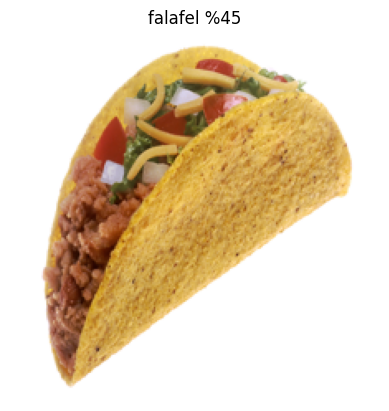

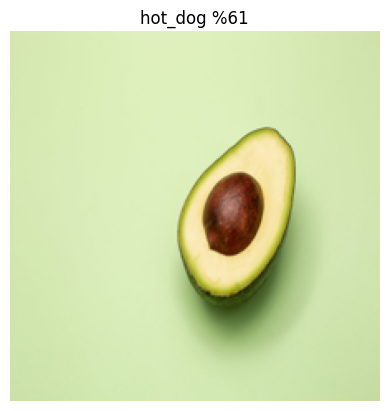

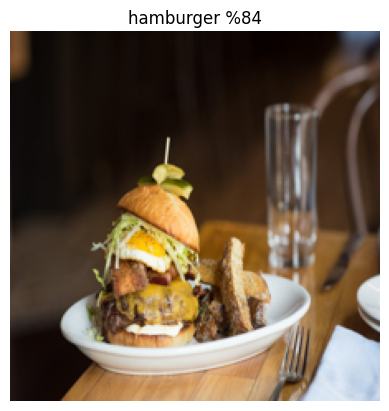

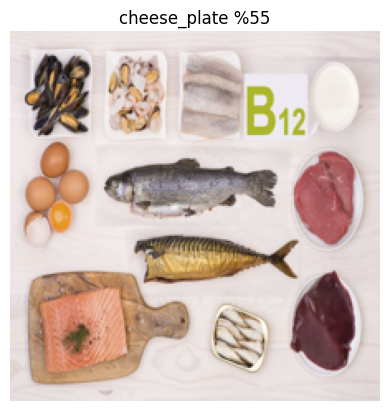

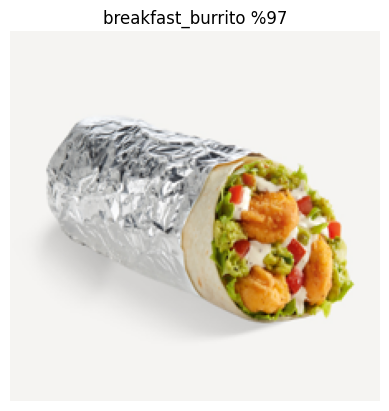

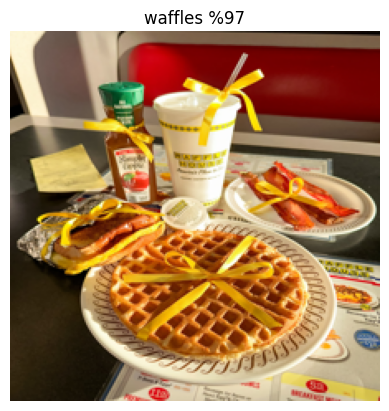

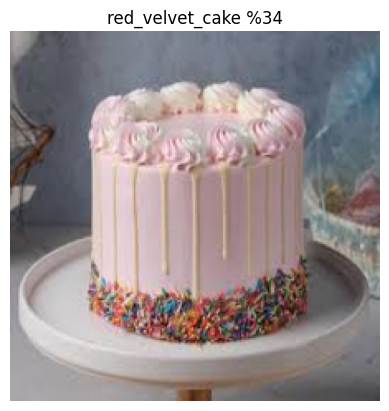

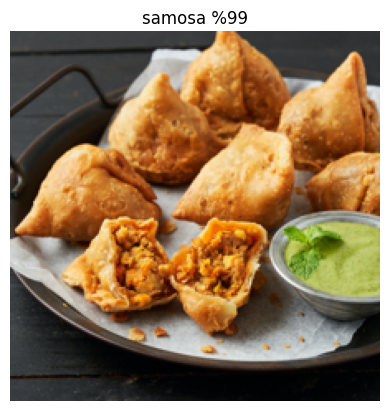

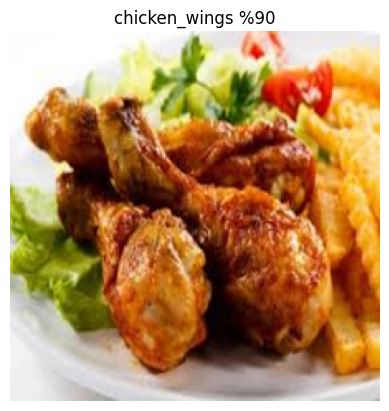

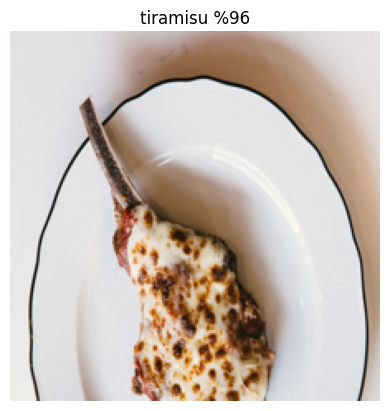

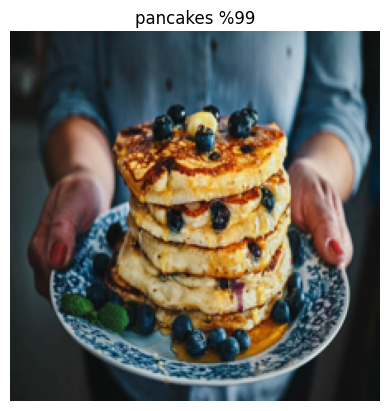

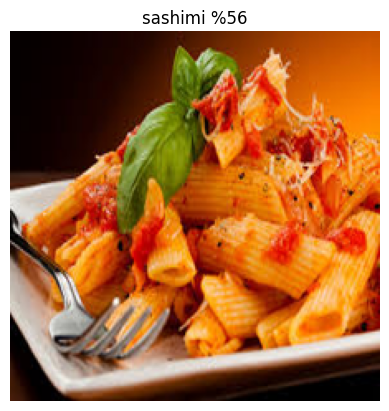

In [ ]:
# Testing the model in random imgs from web
import os
from PIL import Image

images_urls = os.listdir('pics')
# for image in images_urls:

for image_url in images_urls:
  img = Image.open('pics/'+image_url)
  img = img.resize((224,224))
  prediction = model.predict(np.expand_dims(np.array(img),0),verbose=0)
  perc = np.max(prediction)
  label = np.argmax(prediction)
  plt.imshow(np.array(img))
  plt.title(f'{class_names[label]} %{int(perc*100)}')
  plt.axis(False)
  plt.show()